### Library imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from tensorflow import keras as k
import np_utils
import cv2
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense
from keras.preprocessing.image import img_to_array, ImageDataGenerator

## Preproccessing Part

### Preprocessing Steps for One Example Image


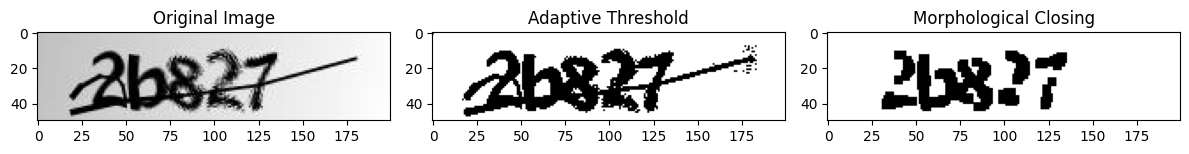

In [28]:
example_path = './dataset/2b827.png'
image = cv2.imread(example_path, cv2.IMREAD_GRAYSCALE)

# Display the original image
plt.figure(figsize=(12, 12))
plt.subplot(231)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# Adaptive thresholding is used to convert a grayscale image to a binary image
image_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
plt.subplot(232)
plt.imshow(image_thresh, cmap='gray')
plt.title('Adaptive Threshold')

# Closing is a morphological operation that removes small holes and gaps in the foreground
kernel = np.ones((5,5), np.uint8)
image_close = cv2.morphologyEx(image_thresh, cv2.MORPH_CLOSE, kernel)
plt.subplot(233)
plt.imshow(image_close, cmap='gray')
plt.title('Morphological Closing')


# Show the figure with subplots
plt.tight_layout()
plt.show()

### Loading Dataset and Apply Preprocessing for all dataset

In [3]:
X=[]
y=[]

# List all files in the dataset directory
for filename in os.listdir('./dataset'):
    path = os.path.join('./dataset', filename)
    
    
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    
    kernel = np.ones((5,5), np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    
    # kernel = np.ones((2,2), np.uint8)
    # image = cv2.dilate(image, kernel, iterations=1)
    
    # image = cv2.GaussianBlur(image, (5,5), 0)
    
    # Splitting up the image into sections of each character
    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90], image[10:50, 90:110], image[10:50, 110:130]]


    # Labelling segments with the image name
    for i in range(5):
        X.append(img_to_array(Image.fromarray(x[i])))
        # data values are stored in the filename so the last 5 characters are extracted
        y.append(path[len(path)-9:len(path)-4][i])

X = np.array(X)
y = np.array(y)

Dataset consist of 1070 items. And every image has 5 characters. After the preprocessing part
extract the all characters from image so that input and output shape mutliplied by 5.
And this resuls should be 1070 * 5 = 5350

In [4]:
X.shape, y.shape

((5360, 40, 20, 1), (5360,))

### Scaling X values to grayscale images

In [5]:
X=X.astype('float32')
X/=255

### Apply one hot and label encoding for y values

In [6]:
y_le = LabelEncoder().fit_transform(y)
y_ohe = OneHotEncoder(sparse = False).fit_transform(y_le.reshape(len(y_le),1))

c:\Users\bedirhan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Data Splitting Part

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size = 0.2, random_state = 42)

row, col = X.shape[1],X.shape[2]
categories = y_ohe.shape[1]

info = {y_le[i] : y[i] for i in range(len(y))}

## Creating the CNN architecture

In [8]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same', input_shape=(row,col,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(2000))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 20, 16)        160       
                                                                 
 activation (Activation)     (None, 40, 20, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 10, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 10, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 20, 10, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 5, 16)         0         
 g2D)                                                

# Model Training Part

In [9]:
batch_size = 100
epochs = 50

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True)

Epoch 1/50


43/43 [==============================] - 3s 33ms/step - loss: 2.9290 - accuracy: 0.0944 - val_loss: 2.5444 - val_accuracy: 0.2062
Epoch 2/50
43/43 [==============================] - 1s 32ms/step - loss: 2.0786 - accuracy: 0.3563 - val_loss: 1.6001 - val_accuracy: 0.5131
Epoch 3/50
43/43 [==============================] - 1s 25ms/step - loss: 1.5509 - accuracy: 0.5518 - val_loss: 1.2111 - val_accuracy: 0.6866
Epoch 4/50
43/43 [==============================] - 1s 26ms/step - loss: 1.2322 - accuracy: 0.6423 - val_loss: 0.9481 - val_accuracy: 0.7603
Epoch 5/50
43/43 [==============================] - 1s 26ms/step - loss: 1.0514 - accuracy: 0.7010 - val_loss: 0.8652 - val_accuracy: 0.7687
Epoch 6/50
43/43 [==============================] - 1s 26ms/step - loss: 0.9409 - accuracy: 0.7288 - val_loss: 0.7654 - val_accuracy: 0.7976
Epoch 7/50
43/43 [==============================] - 1s 26ms/step - loss: 0.8594 - accuracy: 0.7535 - val_loss: 0.7236 - val_accuracy: 0.8097
Epoch 8/50


## Performance Evaluation Part

In [10]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

34/34 [==============================] - 0s 7ms/step - loss: 0.5819 - accuracy: 0.8685
Test loss: 0.5818846225738525
Test accuracy: 0.8684701323509216


## Prediction Function


In [11]:
def predict_example_image (img_path) :
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    kernel = np.ones((5,5),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    
    
    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]
    
    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))
    
    X_pred = np.array(X_pred)
    X_pred/= 255.0
    
    y_pred = model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1)
    
    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')
        
    print('\nActual:    ', img_path[len(img_path)-9:len(img_path)-4])

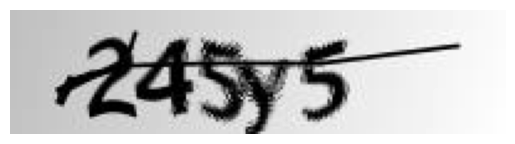

1/1 [==============================] - 0s 149ms/step
Prediction: 245y5
Actual:     245y5


In [12]:
predict_example_image('./dataset/245y5.png')

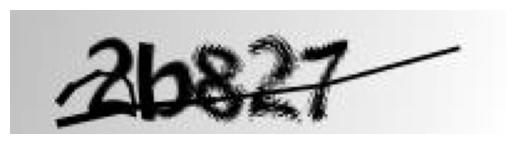

1/1 [==============================] - 0s 37ms/step
Prediction: 2b827
Actual:     2b827


In [14]:
predict_example_image('./dataset/2b827.png')

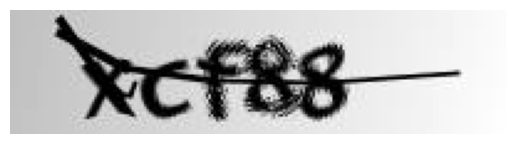

1/1 [==============================] - 0s 33ms/step
Prediction: xcf88
Actual:     xcf88


In [15]:
predict_example_image('./dataset/xcf88.png')

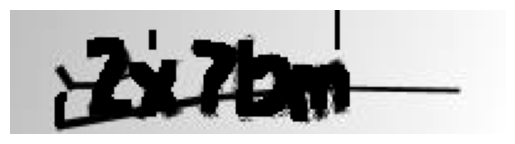

1/1 [==============================] - 0s 45ms/step
Prediction: 2c7bm
Actual:     2x7bm


In [16]:
# create a similar capthca from paint
predict_example_image('./dataset/2x7bm.png')